In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Paraíba - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_PB.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Paraíba - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Paraíba - Produção de Cimento (t),Paraíba - value,Paraíba - IDH,Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Paraíba - PIB - Per Capita,Paraíba - PIB - Preços de Mercado,Paraíba - Consumo de Cimento (t)
0,2003-1,8.315958,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,118.926160,0.182304,0.656510,3.017292e+07,1.631334e+06,7.291169,2.736342e+07,38.426
1,2003-2,8.309895,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,117.724891,0.185909,0.656949,3.021010e+07,1.632950e+06,7.293438,2.737516e+07,31.672
2,2003-3,8.303831,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,118.501965,0.189593,0.657388,3.024728e+07,1.634566e+06,7.295708,2.738689e+07,28.775
3,2003-4,8.297767,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,119.390679,0.193353,0.657827,3.028445e+07,1.636182e+06,7.297978,2.739862e+07,28.571
4,2003-5,8.291704,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,121.517541,0.197186,0.658266,3.032163e+07,1.637798e+06,7.300247,2.741035e+07,31.613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,294.165653,0.679715,NaN,NaN,NaN,NaN,NaN,95.860
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,293.457511,0.678961,NaN,NaN,NaN,NaN,NaN,90.790
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,292.809622,0.677475,NaN,NaN,NaN,NaN,NaN,94.588
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,290.980478,0.676277,NaN,NaN,NaN,NaN,NaN,89.777


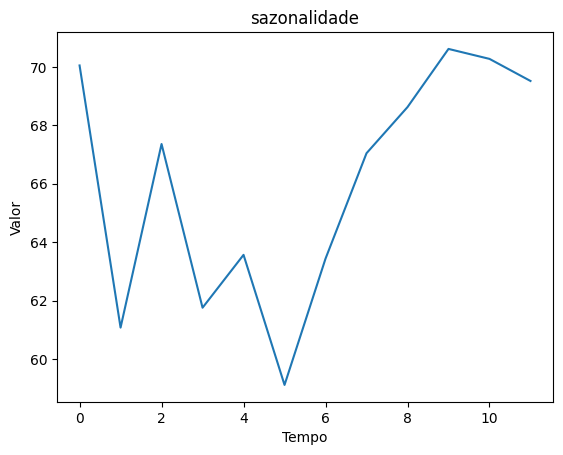

,sazonalidade
sazonalidade,
0,70.054429
1,61.071714
2,67.362821
3,61.753643
4,63.564929
5,59.108000
6,63.435071
7,67.047000
8,68.628143


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Paraíba - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Paraíba - Produção de Cimento (t),Paraíba - value,Paraíba - IDH,Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Paraíba - PIB - Per Capita,Paraíba - PIB - Preços de Mercado,sazonalidade,Paraíba - Consumo de Cimento (t)
0,2003-1,8.315958,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,118.926160,0.182304,0.656510,3.017292e+07,1.631334e+06,7.291169,2.736342e+07,70.054429,38.426
1,2003-2,8.309895,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,117.724891,0.185909,0.656949,3.021010e+07,1.632950e+06,7.293438,2.737516e+07,61.071714,31.672
2,2003-3,8.303831,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,118.501965,0.189593,0.657388,3.024728e+07,1.634566e+06,7.295708,2.738689e+07,67.362821,28.775
3,2003-4,8.297767,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,119.390679,0.193353,0.657827,3.028445e+07,1.636182e+06,7.297978,2.739862e+07,61.753643,28.571
4,2003-5,8.291704,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,121.517541,0.197186,0.658266,3.032163e+07,1.637798e+06,7.300247,2.741035e+07,63.564929,31.613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,294.165653,0.679715,NaN,NaN,NaN,NaN,NaN,67.047000,95.860
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,293.457511,0.678961,NaN,NaN,NaN,NaN,NaN,68.628143,90.790
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,292.809622,0.677475,NaN,NaN,NaN,NaN,NaN,70.621071,94.588
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,290.980478,0.676277,NaN,NaN,NaN,NaN,NaN,70.279643,89.777


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      32.450
1      27.763
2      30.131
3      27.103
4      28.053
        ...  
235       NaN
236       NaN
237       NaN
238       NaN
239       NaN
Name: Paraíba - Consumo de Cimento (t), Length: 240, dtype: float64

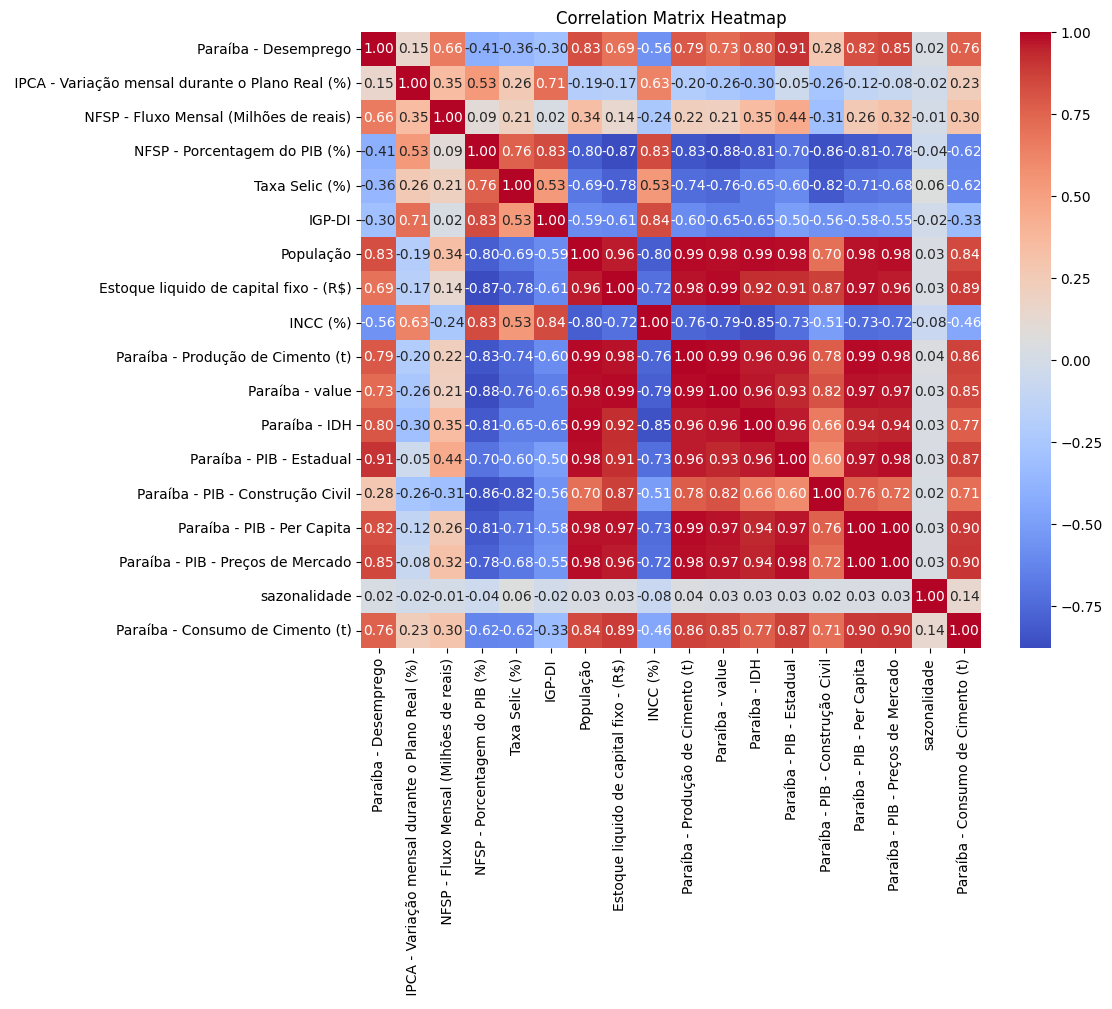

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.fillna(0.0).iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Paraíba - Desemprego,3.921573e+03
1,IPCA - Variação mensal durante o Plano Real (%),1.731728e+03
2,NFSP - Fluxo Mensal (Milhões de reais),2.837162e+02
3,NFSP - Porcentagem do PIB (%),2.588072e+02
4,Taxa Selic (%),6.119448e+01
5,IGP-DI,2.659082e+02
6,População,3.316691e+06
7,Estoque liquido de capital fixo - (R$),9.263881e+06
8,INCC (%),1.175283e+03
9,Paraíba - Produção de Cimento (t),2.477119e+04


In [39]:
data = remove_high_vif_columns(safe_data, 10000000)
data

Num columns removed: 1


,Paraíba - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Paraíba - Produção de Cimento (t),Paraíba - value,Paraíba - IDH,Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Paraíba - PIB - Per Capita,sazonalidade
0,8.315958,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,118.926160,0.182304,0.656510,3.017292e+07,1.631334e+06,7.291169,70.054429
1,8.309895,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,117.724891,0.185909,0.656949,3.021010e+07,1.632950e+06,7.293438,61.071714
2,8.303831,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,118.501965,0.189593,0.657388,3.024728e+07,1.634566e+06,7.295708,67.362821
3,8.297767,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,119.390679,0.193353,0.657827,3.028445e+07,1.636182e+06,7.297978,61.753643
4,8.291704,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,121.517541,0.197186,0.658266,3.032163e+07,1.637798e+06,7.300247,63.564929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,11.099253,0.366904,-5783.316460,2.206994,0.545067,0.471521,1.987710e+08,7.783063e+06,0.378150,198.799183,0.560149,0.699635,3.602670e+07,1.708751e+06,7.486100,67.047000
176,11.101732,0.358935,-6001.730740,2.215328,0.782910,0.476827,1.988450e+08,7.780841e+06,0.377666,199.062337,0.560154,0.699510,3.601732e+07,1.708600e+06,7.485481,68.628143
177,11.104211,0.354313,-6454.887704,2.232466,0.909682,0.475427,1.989190e+08,7.778619e+06,0.377838,200.716313,0.560115,0.699385,3.600795e+07,1.708449e+06,7.484863,70.621071
178,11.106690,0.352728,-6243.191421,2.263185,1.050614,0.491301,1.989930e+08,7.776397e+06,0.370057,202.015097,0.560068,0.699260,3.599858e+07,1.708298e+06,7.484244,70.279643


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Paraíba - Produção de Cimento (t),Paraíba - value,Paraíba - IDH,Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Paraíba - PIB - Per Capita
0,2.802383,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-2.155869,-2.356232,-2.133127,-1.653660,-2.419929,-2.189838
1,2.402642,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-2.207659,-2.324477,-2.096603,-1.635121,-2.373764,-2.154148
2,2.158351,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-2.174157,-2.292026,-2.060080,-1.616582,-2.327599,-2.118457
3,2.049492,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-2.135843,-2.258905,-2.023557,-1.598043,-2.281434,-2.082767
4,1.905441,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-2.044149,-2.225141,-1.987034,-1.579504,-2.235269,-2.047076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-1.429358,0.425789,-0.584804,-1.503380,-0.514871,1.368581,0.605679,-1.872446,1.287639,0.972246,1.453961,1.265450,-0.208279,0.875578
176,-1.523783,0.339575,-0.580461,-0.733634,-0.473208,1.380202,0.591420,-1.876611,1.298984,0.972293,1.443569,1.260776,-0.212596,0.865848
177,-1.578548,0.160702,-0.571531,-0.323353,-0.484199,1.391823,0.577161,-1.875135,1.370290,0.971950,1.433178,1.256102,-0.216913,0.856119
178,-1.597335,0.244264,-0.555524,0.132757,-0.359568,1.403443,0.562902,-1.942040,1.426284,0.971530,1.422787,1.251428,-0.221230,0.846389


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Paraíba - Produção de Cimento (t),Paraíba - value,Paraíba - IDH,Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Paraíba - PIB - Per Capita
0,2.802383,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-2.155869,-2.356232,-2.133127,-1.653660,-2.419929,-2.189838
1,2.402642,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-2.207659,-2.324477,-2.096603,-1.635121,-2.373764,-2.154148
2,2.158351,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-2.174157,-2.292026,-2.060080,-1.616582,-2.327599,-2.118457
3,2.049492,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-2.135843,-2.258905,-2.023557,-1.598043,-2.281434,-2.082767
4,1.905441,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-2.044149,-2.225141,-1.987034,-1.579504,-2.235269,-2.047076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,-0.960452,1.465326,-0.676734,0.472779,-1.087000,1.228701,0.759879,-1.491033,0.947670,0.992970,1.536781,1.289972,-0.146262,0.949340
164,-1.007966,1.351131,-0.668750,0.302784,-0.904679,1.240408,0.749001,-1.525186,0.968279,0.992955,1.534765,1.291611,-0.152621,0.948209
165,-0.976556,1.143146,-0.657609,0.339539,-0.900134,1.252114,0.738124,-1.546744,0.976191,0.992207,1.532749,1.293251,-0.158981,0.947078
166,-1.146834,1.542609,-0.647588,0.472795,-1.136836,1.263821,0.727246,-1.586381,0.994579,0.991355,1.530732,1.294890,-0.165341,0.945947


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      32.450
1      27.763
2      30.131
3      27.103
4      28.053
        ...  
163    64.217
164    57.591
165    64.307
166    61.971
167    57.480
Name: Paraíba - Consumo de Cimento (t), Length: 168, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 14)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Paraíba - Produção de Cimento (t),Paraíba - value,Paraíba - IDH,Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Paraíba - PIB - Per Capita
132,1.530065,0.817451,-0.366715,-0.530011,0.174628,0.848407,0.965586,-0.066954,0.833487,0.839233,0.610939,1.048365,0.702803,1.147751
133,1.649361,1.130195,-0.350285,-0.532694,0.240832,0.861179,0.962419,-0.130652,0.823848,0.846989,0.610650,1.060532,0.668042,1.139653
134,1.622916,1.160498,-0.335122,-0.186421,0.176857,0.873950,0.959252,-0.079602,0.830934,0.853974,0.610361,1.072698,0.633281,1.131555
135,1.581460,1.131990,-0.321950,-0.719664,-0.005233,0.886722,0.956085,-0.034473,0.838021,0.860865,0.610072,1.084865,0.598521,1.123457
136,1.638292,1.384387,-0.302995,-0.798520,0.097576,0.899493,0.952918,-0.177535,0.845588,0.867807,0.609783,1.097032,0.563760,1.115359
137,1.643773,1.375487,-0.290554,-0.612129,0.431487,0.912265,0.949751,-0.208868,0.853061,0.874452,0.609494,1.109198,0.529000,1.107261
138,1.704584,1.438928,-0.281926,-0.476740,0.482414,0.925036,0.946584,-0.245300,0.860646,0.880474,0.609206,1.121365,0.494239,1.099163
139,1.841703,1.569590,-0.275931,-0.211736,0.657043,0.937808,0.943417,-0.333490,0.867555,0.886255,0.608917,1.133532,0.459479,1.091065
140,1.837218,1.584058,-0.271466,-0.484608,0.678386,0.950580,0.940250,-0.296846,0.874599,0.892168,0.608628,1.145698,0.424718,1.082968
141,1.797860,1.166380,-0.273241,-0.183907,0.727143,0.963351,0.937082,-0.292462,0.882044,0.898336,0.608339,1.157865,0.389957,1.074870


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 14)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
#     train, train_val = validation_splitter(train_input, 7)
#     target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(144, activation='tanh', 
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l1(0.01),
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(144, activation='tanh', 
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l1(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(36, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
#                         validation_data=(train_val,
#                                          target_val),
                        validation_split=0.15,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(5)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2796349543, 3118449360, 1462945552, 1436094853, 3098683276]


Step: 0 ___________________________________________
val_loss: 27.534128189086914
winner_seed: 2796349543


Step: 1 ___________________________________________
val_loss: 89.81497192382812


Step: 2 ___________________________________________
val_loss: 40.44272232055664


Step: 3 ___________________________________________
val_loss: 36.258243560791016


Step: 4 ___________________________________________
val_loss: 108.7922592163086


final_seed: 2796349543


In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 1037461789

Epoch 1/10000
4/4 [==============================] - 3s 188ms/step - loss: 6149.5259 - val_loss: 352.9300
Epoch 2/10000
4/4 [==============================] - 0s 14ms/step - loss: 1047.4104 - val_loss: 373.2213
Epoch 3/10000
4/4 [==============================] - 0s 11ms/step - loss: 397.5655 - val_loss: 534.7114
Epoch 4/10000
4/4 [==============================] - 0s 13ms/step - loss: 901.4958 - val_loss: 569.1237
Epoch 5/10000
4/4 [==============================] - 0s 12ms/step - loss: 320.3908 - val_loss: 810.8163
Epoch 6/10000
4/4 [==============================] - 0s 12ms/step - loss: 236.9383 - val_loss: 923.1476
Epoch 7/10000
4/4 [==============================] - 0s 12ms/step - loss: 213.5857 - val_loss: 1230.2247
Epoch 8/10000
4/4 [==============================] - 0s 12ms/step - loss: 199.4675 - val_loss: 1224.7557
Epoch 9/10000
4/4 [==============================] - 0s 12ms/step - loss: 201.4419 - val_loss: 1238.9850
Epoch 10/10000
4/4 [==============================] - 0s 1

4/4 [==============================] - 0s 13ms/step - loss: 89.2651 - val_loss: 76.0395
Epoch 80/10000
4/4 [==============================] - 0s 12ms/step - loss: 93.6140 - val_loss: 88.4440
Epoch 81/10000
4/4 [==============================] - 0s 13ms/step - loss: 91.9391 - val_loss: 88.3868
Epoch 82/10000
4/4 [==============================] - 0s 14ms/step - loss: 93.1261 - val_loss: 98.3425
Epoch 83/10000
4/4 [==============================] - 0s 14ms/step - loss: 101.1204 - val_loss: 76.2851
Epoch 84/10000
4/4 [==============================] - 0s 15ms/step - loss: 85.3147 - val_loss: 98.9558
Epoch 85/10000
4/4 [==============================] - 0s 14ms/step - loss: 88.1668 - val_loss: 97.2406
Epoch 86/10000
4/4 [==============================] - 0s 13ms/step - loss: 90.2379 - val_loss: 96.7590
Epoch 87/10000
4/4 [==============================] - 0s 14ms/step - loss: 83.7322 - val_loss: 84.6368
Epoch 88/10000
4/4 [==============================] - 0s 14ms/step - loss: 80.7755 - va

4/4 [==============================] - 0s 13ms/step - loss: 68.8688 - val_loss: 59.9737
Epoch 159/10000
4/4 [==============================] - 0s 13ms/step - loss: 82.6560 - val_loss: 59.1981
Epoch 160/10000
4/4 [==============================] - 0s 13ms/step - loss: 81.0684 - val_loss: 56.7717
Epoch 161/10000
4/4 [==============================] - 0s 13ms/step - loss: 74.9734 - val_loss: 56.7178
Epoch 162/10000
4/4 [==============================] - 0s 13ms/step - loss: 75.0423 - val_loss: 58.1795
Epoch 163/10000
4/4 [==============================] - 0s 12ms/step - loss: 74.5303 - val_loss: 61.1121
Epoch 164/10000
4/4 [==============================] - 0s 13ms/step - loss: 71.5503 - val_loss: 57.9532
Epoch 165/10000
4/4 [==============================] - 0s 12ms/step - loss: 74.0399 - val_loss: 56.8032
Epoch 166/10000
4/4 [==============================] - 0s 12ms/step - loss: 76.3289 - val_loss: 94.8252
Epoch 167/10000
4/4 [==============================] - 0s 13ms/step - loss: 92.4

Epoch 237/10000
4/4 [==============================] - 0s 13ms/step - loss: 64.2784 - val_loss: 56.6115
Epoch 238/10000
4/4 [==============================] - 0s 13ms/step - loss: 59.5519 - val_loss: 66.3359
Epoch 239/10000
4/4 [==============================] - 0s 13ms/step - loss: 63.2979 - val_loss: 53.3574
Epoch 240/10000
4/4 [==============================] - 0s 13ms/step - loss: 59.2026 - val_loss: 58.0514
Epoch 241/10000
4/4 [==============================] - 0s 13ms/step - loss: 57.2705 - val_loss: 53.6376
Epoch 242/10000
4/4 [==============================] - 0s 13ms/step - loss: 59.3983 - val_loss: 62.2604
Epoch 243/10000
4/4 [==============================] - 0s 13ms/step - loss: 60.0860 - val_loss: 56.3584
Epoch 244/10000
4/4 [==============================] - 0s 13ms/step - loss: 58.5970 - val_loss: 54.9091
Epoch 245/10000
4/4 [==============================] - 0s 12ms/step - loss: 67.5358 - val_loss: 68.2757
Epoch 246/10000
4/4 [==============================] - 0s 12ms/s

Epoch 316/10000
4/4 [==============================] - 0s 12ms/step - loss: 53.2860 - val_loss: 56.1579
Epoch 317/10000
4/4 [==============================] - 0s 12ms/step - loss: 53.8545 - val_loss: 59.0659
Epoch 318/10000
4/4 [==============================] - 0s 13ms/step - loss: 52.4277 - val_loss: 54.1155
Epoch 319/10000
4/4 [==============================] - 0s 12ms/step - loss: 52.0130 - val_loss: 54.8951
Epoch 320/10000
4/4 [==============================] - 0s 12ms/step - loss: 51.8013 - val_loss: 51.3935
Epoch 321/10000
4/4 [==============================] - 0s 13ms/step - loss: 52.9077 - val_loss: 46.4950
Epoch 322/10000
4/4 [==============================] - 0s 13ms/step - loss: 51.2234 - val_loss: 49.2196
Epoch 323/10000
4/4 [==============================] - 0s 12ms/step - loss: 50.6916 - val_loss: 54.0247
Epoch 324/10000
4/4 [==============================] - 0s 13ms/step - loss: 51.1118 - val_loss: 51.3917
Epoch 325/10000
4/4 [==============================] - 0s 13ms/s

Epoch 395/10000
4/4 [==============================] - 0s 12ms/step - loss: 46.1930 - val_loss: 46.9883
Epoch 396/10000
4/4 [==============================] - 0s 13ms/step - loss: 46.7240 - val_loss: 45.8886
Epoch 397/10000
4/4 [==============================] - 0s 14ms/step - loss: 49.5684 - val_loss: 45.0703
Epoch 398/10000
4/4 [==============================] - 0s 13ms/step - loss: 50.7805 - val_loss: 42.7465
Epoch 399/10000
4/4 [==============================] - 0s 14ms/step - loss: 46.0774 - val_loss: 37.6367
Epoch 400/10000
4/4 [==============================] - 0s 14ms/step - loss: 46.2462 - val_loss: 40.9486
Epoch 401/10000
4/4 [==============================] - 0s 13ms/step - loss: 47.3041 - val_loss: 39.8511
Epoch 402/10000
4/4 [==============================] - 0s 13ms/step - loss: 46.3597 - val_loss: 43.3460
Epoch 403/10000
4/4 [==============================] - 0s 13ms/step - loss: 46.4428 - val_loss: 43.7458
Epoch 404/10000
4/4 [==============================] - 0s 13ms/s

Epoch 474/10000
4/4 [==============================] - 0s 13ms/step - loss: 42.2659 - val_loss: 35.1922
Epoch 475/10000
4/4 [==============================] - 0s 13ms/step - loss: 42.0980 - val_loss: 34.5751
Epoch 476/10000
4/4 [==============================] - 0s 13ms/step - loss: 41.7866 - val_loss: 34.3665
Epoch 477/10000
4/4 [==============================] - 0s 13ms/step - loss: 45.9996 - val_loss: 35.1106
Epoch 478/10000
4/4 [==============================] - 0s 14ms/step - loss: 42.4464 - val_loss: 34.0215
Epoch 479/10000
4/4 [==============================] - 0s 13ms/step - loss: 43.6873 - val_loss: 34.3066
Epoch 480/10000
4/4 [==============================] - 0s 13ms/step - loss: 48.4974 - val_loss: 35.9843
Epoch 481/10000
4/4 [==============================] - 0s 12ms/step - loss: 53.2066 - val_loss: 36.7914
Epoch 482/10000
4/4 [==============================] - 0s 12ms/step - loss: 52.1542 - val_loss: 35.0741
Epoch 483/10000
4/4 [==============================] - 0s 12ms/s

Epoch 553/10000
4/4 [==============================] - 0s 15ms/step - loss: 36.0739 - val_loss: 34.5852
Epoch 554/10000
4/4 [==============================] - 0s 13ms/step - loss: 38.0341 - val_loss: 36.2952
Epoch 555/10000
4/4 [==============================] - 0s 13ms/step - loss: 35.5059 - val_loss: 36.5336
Epoch 556/10000
4/4 [==============================] - 0s 14ms/step - loss: 36.6725 - val_loss: 37.3272
Epoch 557/10000
4/4 [==============================] - 0s 13ms/step - loss: 45.3561 - val_loss: 34.4393
Epoch 558/10000
4/4 [==============================] - 0s 13ms/step - loss: 38.8407 - val_loss: 35.4648
Epoch 559/10000
4/4 [==============================] - 0s 14ms/step - loss: 37.9057 - val_loss: 39.5118
Epoch 560/10000
4/4 [==============================] - 0s 15ms/step - loss: 36.2756 - val_loss: 37.5837
Epoch 561/10000
4/4 [==============================] - 0s 14ms/step - loss: 39.2761 - val_loss: 40.5130
Epoch 562/10000
4/4 [==============================] - 0s 14ms/s

Epoch 632/10000
4/4 [==============================] - 0s 13ms/step - loss: 33.3988 - val_loss: 34.2638
Epoch 633/10000
4/4 [==============================] - 0s 13ms/step - loss: 36.5210 - val_loss: 32.1476
Epoch 634/10000
4/4 [==============================] - 0s 12ms/step - loss: 35.5515 - val_loss: 31.4220
Epoch 635/10000
4/4 [==============================] - 0s 13ms/step - loss: 37.5772 - val_loss: 33.6968
Epoch 636/10000
4/4 [==============================] - 0s 13ms/step - loss: 32.7459 - val_loss: 31.6326
Epoch 637/10000
4/4 [==============================] - 0s 13ms/step - loss: 33.2800 - val_loss: 31.1933
Epoch 638/10000
4/4 [==============================] - 0s 13ms/step - loss: 33.1003 - val_loss: 31.7744
Epoch 639/10000
4/4 [==============================] - 0s 12ms/step - loss: 33.7670 - val_loss: 33.5006
Epoch 640/10000
4/4 [==============================] - 0s 12ms/step - loss: 32.9086 - val_loss: 31.0885
Epoch 641/10000
4/4 [==============================] - 0s 11ms/s

Epoch 711/10000
4/4 [==============================] - 0s 13ms/step - loss: 31.9638 - val_loss: 42.8514
Epoch 712/10000
4/4 [==============================] - 0s 13ms/step - loss: 32.0106 - val_loss: 43.0649
Epoch 713/10000
4/4 [==============================] - 0s 13ms/step - loss: 31.9609 - val_loss: 38.3947
Epoch 714/10000
4/4 [==============================] - 0s 13ms/step - loss: 32.3027 - val_loss: 38.5604
Epoch 715/10000
4/4 [==============================] - 0s 13ms/step - loss: 35.6883 - val_loss: 38.4023
Epoch 716/10000
4/4 [==============================] - 0s 12ms/step - loss: 33.9742 - val_loss: 38.5355
Epoch 717/10000
4/4 [==============================] - 0s 13ms/step - loss: 32.3947 - val_loss: 39.1082
Epoch 718/10000
4/4 [==============================] - 0s 12ms/step - loss: 31.8686 - val_loss: 37.9173
Epoch 719/10000
4/4 [==============================] - 0s 12ms/step - loss: 31.6568 - val_loss: 38.5013
Epoch 720/10000
4/4 [==============================] - 0s 13ms/s

Epoch 790/10000
4/4 [==============================] - 0s 14ms/step - loss: 32.1498 - val_loss: 28.3495
Epoch 791/10000
4/4 [==============================] - 0s 13ms/step - loss: 28.9592 - val_loss: 29.1204
Epoch 792/10000
4/4 [==============================] - 0s 12ms/step - loss: 30.3230 - val_loss: 28.1529
Epoch 793/10000
4/4 [==============================] - 0s 14ms/step - loss: 28.2843 - val_loss: 27.8986
Epoch 794/10000
4/4 [==============================] - 0s 12ms/step - loss: 27.9946 - val_loss: 30.1216
Epoch 795/10000
4/4 [==============================] - 0s 13ms/step - loss: 29.1877 - val_loss: 28.6463
Epoch 796/10000
4/4 [==============================] - 0s 12ms/step - loss: 28.2293 - val_loss: 28.8671
Epoch 797/10000
4/4 [==============================] - 0s 11ms/step - loss: 29.0779 - val_loss: 30.7248
Epoch 798/10000
4/4 [==============================] - 0s 13ms/step - loss: 27.8776 - val_loss: 27.5828
Epoch 799/10000
4/4 [==============================] - 0s 12ms/s

Epoch 869/10000
4/4 [==============================] - 0s 12ms/step - loss: 38.2707 - val_loss: 34.6217
Epoch 870/10000
4/4 [==============================] - 0s 12ms/step - loss: 67.0096 - val_loss: 33.9929
Epoch 871/10000
4/4 [==============================] - 0s 12ms/step - loss: 37.2022 - val_loss: 41.3102
Epoch 872/10000
4/4 [==============================] - 0s 12ms/step - loss: 31.8037 - val_loss: 36.7258
Epoch 873/10000
4/4 [==============================] - 0s 13ms/step - loss: 47.2435 - val_loss: 41.1549
Epoch 874/10000
4/4 [==============================] - 0s 13ms/step - loss: 74.6296 - val_loss: 62.7525
Epoch 875/10000
4/4 [==============================] - 0s 12ms/step - loss: 1002.3543 - val_loss: 522.7955
Epoch 876/10000
4/4 [==============================] - 0s 12ms/step - loss: 660.2119 - val_loss: 471.1682
Epoch 877/10000
4/4 [==============================] - 0s 12ms/step - loss: 235.0935 - val_loss: 98.4635
Epoch 878/10000
4/4 [==============================] - 0s 

4/4 [==============================] - 0s 13ms/step - loss: 75.7209 - val_loss: 90.7634
Epoch 948/10000
4/4 [==============================] - 0s 13ms/step - loss: 71.4485 - val_loss: 91.4402
Epoch 949/10000
4/4 [==============================] - 0s 13ms/step - loss: 72.0108 - val_loss: 87.0126
Epoch 950/10000
4/4 [==============================] - 0s 14ms/step - loss: 71.0710 - val_loss: 89.7028
Epoch 951/10000
4/4 [==============================] - 0s 14ms/step - loss: 77.0602 - val_loss: 88.8680
Epoch 952/10000
4/4 [==============================] - 0s 12ms/step - loss: 76.5149 - val_loss: 98.1494
Epoch 953/10000
4/4 [==============================] - 0s 13ms/step - loss: 72.6298 - val_loss: 86.9759
Epoch 954/10000
4/4 [==============================] - 0s 13ms/step - loss: 71.6414 - val_loss: 90.3009
Epoch 955/10000
4/4 [==============================] - 0s 14ms/step - loss: 74.5173 - val_loss: 83.1781
Epoch 956/10000
4/4 [==============================] - 0s 16ms/step - loss: 72.3

4/4 [==============================] - 0s 13ms/step - loss: 70.9970 - val_loss: 92.2457
Epoch 1026/10000
4/4 [==============================] - 0s 12ms/step - loss: 71.6282 - val_loss: 79.4062
Epoch 1027/10000
4/4 [==============================] - 0s 13ms/step - loss: 62.4836 - val_loss: 79.9531
Epoch 1028/10000
4/4 [==============================] - 0s 12ms/step - loss: 62.8288 - val_loss: 79.3622
Epoch 1029/10000
4/4 [==============================] - 0s 12ms/step - loss: 62.3731 - val_loss: 78.9263
Epoch 1030/10000
4/4 [==============================] - 0s 12ms/step - loss: 60.8511 - val_loss: 76.0490
Epoch 1031/10000
4/4 [==============================] - 0s 13ms/step - loss: 63.0348 - val_loss: 79.7651
Epoch 1032/10000
4/4 [==============================] - 0s 12ms/step - loss: 65.7544 - val_loss: 76.7945
Epoch 1033/10000
4/4 [==============================] - 0s 12ms/step - loss: 62.9234 - val_loss: 79.0478
Epoch 1034/10000
4/4 [==============================] - 0s 12ms/step - l

4/4 [==============================] - 0s 12ms/step - loss: 53.7920 - val_loss: 85.4032
Epoch 1104/10000
4/4 [==============================] - 0s 12ms/step - loss: 56.8900 - val_loss: 77.3265
Epoch 1105/10000
4/4 [==============================] - 0s 12ms/step - loss: 56.6630 - val_loss: 90.7532
Epoch 1106/10000
4/4 [==============================] - 0s 12ms/step - loss: 63.8318 - val_loss: 63.5092
Epoch 1107/10000
4/4 [==============================] - 0s 12ms/step - loss: 56.8862 - val_loss: 78.9966
Epoch 1108/10000
4/4 [==============================] - 0s 13ms/step - loss: 54.4969 - val_loss: 88.3785
Epoch 1109/10000
4/4 [==============================] - 0s 12ms/step - loss: 58.9323 - val_loss: 71.6993
Epoch 1110/10000
4/4 [==============================] - 0s 13ms/step - loss: 54.2191 - val_loss: 72.1579
Epoch 1111/10000
4/4 [==============================] - 0s 12ms/step - loss: 52.8858 - val_loss: 68.8461
Epoch 1112/10000
4/4 [==============================] - 0s 13ms/step - l

4/4 [==============================] - 0s 12ms/step - loss: 50.6863 - val_loss: 62.7038
Epoch 1182/10000
4/4 [==============================] - 0s 12ms/step - loss: 51.7933 - val_loss: 62.6791
Epoch 1183/10000
4/4 [==============================] - 0s 12ms/step - loss: 52.1660 - val_loss: 61.4246
Epoch 1184/10000
4/4 [==============================] - 0s 12ms/step - loss: 50.3519 - val_loss: 62.3887
Epoch 1185/10000
4/4 [==============================] - 0s 13ms/step - loss: 56.3514 - val_loss: 64.0824
Epoch 1186/10000
4/4 [==============================] - 0s 11ms/step - loss: 50.9128 - val_loss: 62.3954
Epoch 1187/10000
4/4 [==============================] - 0s 12ms/step - loss: 50.5375 - val_loss: 74.0009
Epoch 1188/10000
4/4 [==============================] - 0s 12ms/step - loss: 53.2414 - val_loss: 61.0052
Epoch 1189/10000
4/4 [==============================] - 0s 11ms/step - loss: 49.8286 - val_loss: 76.5657
Epoch 1190/10000
4/4 [==============================] - 0s 12ms/step - l

4/4 [==============================] - 0s 13ms/step - loss: 45.2073 - val_loss: 56.6571
Epoch 1260/10000
4/4 [==============================] - 0s 15ms/step - loss: 44.3820 - val_loss: 54.1941
Epoch 1261/10000
4/4 [==============================] - 0s 13ms/step - loss: 45.9720 - val_loss: 52.3888
Epoch 1262/10000
4/4 [==============================] - 0s 13ms/step - loss: 46.8021 - val_loss: 96.2701
Epoch 1263/10000
4/4 [==============================] - 0s 13ms/step - loss: 44.5182 - val_loss: 71.5318
Epoch 1264/10000
4/4 [==============================] - 0s 13ms/step - loss: 45.0378 - val_loss: 74.3548
Epoch 1265/10000
4/4 [==============================] - 0s 12ms/step - loss: 43.2220 - val_loss: 160.5536
Epoch 1266/10000
4/4 [==============================] - 0s 13ms/step - loss: 45.9396 - val_loss: 67.6864
Epoch 1267/10000
4/4 [==============================] - 0s 13ms/step - loss: 44.8408 - val_loss: 61.6607
Epoch 1268/10000
4/4 [==============================] - 0s 13ms/step - 

4/4 [==============================] - 0s 15ms/step - loss: 44.0650 - val_loss: 51.0090
Epoch 1337: early stopping


In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 17ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,60.090813,60.539333,61.111652,61.836319,63.012764,64.708237,66.394005,68.764305,71.674889,74.551407,77.36087,79.915588
Target,68.053,55.231,53.723,57.457,62.755,48.148,62.19,62.219,61.329,81.988,79.341,76.646
Error,7.962189,5.308334,7.388653,4.379318,0.257763,16.560238,4.204006,6.545303,10.34589,7.436592,1.980133,3.269585


In [54]:
display(mae)
display(mape)

6.3031673

0.10622714

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 16ms/step
Ano-11: |Prediction[[809.96014]] - Target[769.08]| =  Error: [[40.880127]]; MAPE:[[0.05315458]]


[array([[40.880127]], dtype=float32)]

40.880127

0.05315458